In [186]:
# 모델 Resnet 18 적용

# 이제 모델과 데이터가 준비되었으니, 데이터에 매개변수를 최적화하여 모델을 학습하고, 검증하고, 테스트할 차례입니다.
# 모델을 학습하는 과정은 반복적인 과정을 거칩니다; 각 반복 단계에서 모델은 출력을 추측하고, 추측과 정답 사이의 오류(손실(loss))를 계산하고,
# (이전 장에서 본 것처럼) 매개변수에 대한 오류의 도함수(derivative)를 수집한 뒤,
# 경사하강법을 사용하여 이 파라미터들을 최적화(optimize)합니다.

import torch
from torch import nn
import numpy as np

import torch.nn.functional as F
import torch.optim as optim
import os
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt


In [187]:
#stride = 건너뛰는 간격. 즉, 여기선 데이터를 얼마나 건너뛰며 볼 것임을 설정. ex : 1= 1픽셀당 하나씩 본다. 2= 2픽셀당 하나씩 본다. (출력 이미지 1/4로 줄어듬.) 3= 3픽셀당 하나씩. (출력 이미지 1/9로 축소)
#kernel = 특징 추출해낼 커널 (필터). 논문에선 7*7사이즈.

class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias = False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()

        # 만약 출력 이미지가 입력보다 축소 됐을 시, shortcut 덧셈도 축소된 이미지에 맞춰 행렬 크기를 조정해야 하므로, 그 코드임 아래는
        if stride !=1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride = stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [188]:
#resnet 18 정의

class Resnet(nn.Module):
    def __init__(self, block, num_block, num_classes=10):
        super(Resnet, self).__init__()
        self.in_planes=64

        self.conv1 = nn.Conv2d(3,64,kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block,64, num_block[0], stride=1)
        self.layer2 = self._make_layer(block,128, num_block[1], stride=2)
        self.layer3 = self._make_layer(block,256, num_block[2], stride=2)
        self.layer4 = self._make_layer(block,512, num_block[3], stride=2)
        self.linear = nn.Linear(512,num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x) # 4x4x512
        x = F.avg_pool2d(x,4) #1x1x512
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

def Resnet18():
    return Resnet(BasicBlock,[2,2,2,2])



In [189]:
# CIFAR-10 데이터 준비

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform_train
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transform_test
)

train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle =False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [190]:
# 하이퍼파라미터(Hyperparameter)

# 하이퍼파라미터(Hyperparameter)는 모델 최적화 과정을 제어할 수 있는 조절 가능한 매개변수입니다.
# 서로 다른 하이퍼파라미터 값은 모델 학습과 수렴율(convergence rate)에 영향을 미칠 수 있습니다.

# 학습 시에는 다음과 같은 하이퍼파라미터를 정의합니다:
# 에폭(epoch) 수 - 데이터셋을 반복하는 횟수

# 배치 크기(batch size) - 매개변수가 갱신되기 전 신경망을 통해 전파된 데이터 샘플의 수

# 학습률(learning rate) - 각 배치/에폭에서 모델의 매개변수를 조절하는 비율. 값이 작을수록 학습 속도가 느려지고, 값이 크면 학습 중 예측할 수 없는 동작이 발생할 수 있습니다.


In [191]:
# 최적화 단계(Optimization Loop)

# 하이퍼파라미터를 설정한 뒤에는 최적화 단계를 통해 모델을 학습하고 최적화할 수 있습니다. 최적화 단계의 각 반복(iteration)을 에폭이라고 부릅니다.

# 하나의 에폭은 다음 두 부분으로 구성됩니다:
# 학습 단계(train loop) - 학습용 데이터셋을 반복(iterate)하고 최적의 매개변수로 수렴합니다.

# 검증/테스트 단계(validation/test loop) - 모델 성능이 개선되고 있는지를 확인하기 위해 테스트 데이터셋을 반복(iterate)합니다.

In [192]:
# 손실 함수(loss function)

# 학습용 데이터를 제공하면, 학습되지 않은 신경망은 정답을 제공하지 않을 확률이 높습니다.
# 손실 함수(loss function)는 획득한 결과와 실제 값 사이의 틀린 정도(degree of dissimilarity)를 측정하며, 학습 중에 이 값을 최소화하려고 합니다.
#  주어진 데이터 샘플을 입력으로 계산한 예측과 정답(label)을 비교하여 손실(loss)을 계산합니다.

# 손실 함수 초기화

loss_fn = nn.CrossEntropyLoss()

In [193]:
# 옵티마이저(Optimizer)

# 최적화는 각 학습 단계에서 모델의 오류를 줄이기 위해 모델 매개변수를 조정하는 과정입니다.
# 최적화 알고리즘은 이 과정이 수행되는 방식(여기에서는 확률적 경사하강법(SGD; Stochastic Gradient Descent))을 정의합니다

# 학습하려는 모델의 매개변수와 학습률(learning rate) 하이퍼파라미터를 등록하여 옵티마이저를 초기화합니다.





In [194]:
# 학습 단계(loop)에서 최적화는 세단계로 이뤄집니다:
# optimizer.zero_grad()를 호출하여 모델 매개변수의 변화도를 재설정합니다. 기본적으로 변화도는 더해지기(add up) 때문에 중복 계산을 막기 위해 반복할 때마다 명시적으로 0으로 설정합니다.

# loss.backwards()를 호출하여 예측 손실(prediction loss)을 역전파합니다. PyTorch는 각 매개변수에 대한 손실의 변화도를 저장합니다.

# 변화도를 계산한 뒤에는 optimizer.step()을 호출하여 역전파 단계에서 수집된 변화도로 매개변수를 조정합니다.

In [195]:
# mixup 기법 구현


# data mixup
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
       # lam = np.random.beta(alpha, alpha)
       lam=0.2
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :] #두 데이터 x, x[index,:]를 임의로 골라,섞는 작업
    y_a, y_b = y, y[index] # x와 x[index :] 에 대한 각각의 라벨을 y_a,y_b라고 저장


    return mixed_x, y_a, y_b, lam #값들 반환

# label mixup
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b) # 섞은 데이터들의 각 라벨에 대한 손실도 계산 후, 각 손실도를 또 mixup.


In [196]:
# training 메소드 정의
device = 'cuda' if torch.cuda.is_available() else 'cpu'

net = Resnet18()
net = net.to(device)
cudnn.benchmark=True

optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay = 0.0002)

def train(epoch):
    print(f'\n[Train epoch: {epoch}]')
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    mixed_print = 0
    figure = plt.figure(figsize=(8, 8))

    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        if batch_idx == 0:
            orig_img_1 = inputs[0].cpu().numpy()
            orig_img_2 = inputs[1].cpu().numpy()
            mixed = 0.5 * orig_img_1 + (1 - 0.5) * orig_img_2

        # mixup data 넣기
        inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, 0.3)
        if batch_idx == 0:
            mixed_img = inputs[0].cpu().numpy()
        inputs = torch.Tensor(inputs)
        targets_a = torch.Tensor(targets_a)
        targets_b = torch.Tensor(targets_b)




        optimizer.zero_grad()
        outputs = net(inputs)

        # mixup 손실 계산
        loss = mixup_criterion(loss_fn, outputs, targets_a, targets_b, lam)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)

        total += targets.size(0)
        # mixup 성능 계산
        # Mixup을 적용한 경우, 정확도를 계산할 때 예측된 클래스가 targets_a 또는 targets_b와 일치하는지를 확인해야 합니다.
        # Mixup은 섞인 데이터에 대한 예측을 수행하므로, 원래의 targets_a와 targets_b 두 가지 레이블 모두를 고려해야 합니다.

        correct += (lam * predicted.eq(targets_a.data).cpu().sum().float()
                    + (1 - lam) * predicted.eq(targets_b.data).cpu().sum().float())

        # predicted.eq(targets_a.data)는 모델의 예측값(predicted)과 targets_a의 값이 일치하는지를 확인합니다.
        # predicted.eq(targets_b.data)는 모델의 예측값과 targets_b의 값이 일치하는지를 확인합니다.

        # 이렇게 함으로써 Mixup을 적용한 경우, 예측된 클래스가 섞인 데이터의 두 레이블 중 어느 하나와 일치하는지 확인하고, 정확하게 예측된 클래스의 개수를 correct에 누적시키는 것입니다.

        if batch_idx % 100 == 99:
            print('\nCurrent batch:', str(batch_idx+1))
            print('Current train accuracy:', str(predicted.eq(targets).sum().item() / targets.size(0)))
            print('Current train loss:', loss.item())




    plt.subplot(1, 3, 1)
    plt.imshow(np.transpose(orig_img_1, (1, 2, 0)))
    plt.title('Original Image 1')
    plt.subplot(1, 3, 2)
    plt.imshow(np.transpose(orig_img_2, (1, 2, 0)))
    plt.title('Original Image 2')
    plt.subplot(1, 3, 3)
    plt.imshow(np.transpose(mixed, (1, 2, 0)))
    plt.title('Mixed-up Image')
    plt.show()

    print('\nTotal train accuarcy:', 100. * correct / total)
    print('Total train loss:', train_loss)

In [197]:
# test 메소드 정의


def test(epoch):
    print(f'\n[ Test epoch: {epoch} ]')
    net.eval()
    loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(test_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = net(inputs)
        loss += loss_fn(outputs, targets).item()
        total += targets.size(0)

        _,predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

    print('\nTest accuarcy:', 100. * correct / total)
    print('Test average loss:', loss / total)

    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(net, './checkpoint/resnet18_cifar10_model.pt')
    torch.save(net.state_dict(), './checkpoint/resnet18_cifar10_state_dict.pt')
    torch.save({
        'model' : net.state_dict(),
        'optimizer': optimizer.state_dict()
    }, './checkpoint/resnet18_cifar10_all.tar')
    print('Model Saved!')


[Train epoch: 0]

Current batch: 100
Current train accuracy: 0.0625
Current train loss: 2.330186128616333

Current batch: 200
Current train accuracy: 0.125
Current train loss: 2.2571334838867188

Current batch: 300
Current train accuracy: 0.03125
Current train loss: 2.1389195919036865

Current batch: 400
Current train accuracy: 0.21875
Current train loss: 2.1331262588500977

Current batch: 500
Current train accuracy: 0.0625
Current train loss: 2.114579916000366

Current batch: 600
Current train accuracy: 0.0625
Current train loss: 2.124751567840576

Current batch: 700
Current train accuracy: 0.0625
Current train loss: 2.195833206176758

Current batch: 800
Current train accuracy: 0.125
Current train loss: 2.0022737979888916

Current batch: 900
Current train accuracy: 0.125
Current train loss: 2.0218923091888428

Current batch: 1000
Current train accuracy: 0.28125
Current train loss: 2.1726906299591064

Current batch: 1100
Current train accuracy: 0.0
Current train loss: 2.04779410362243

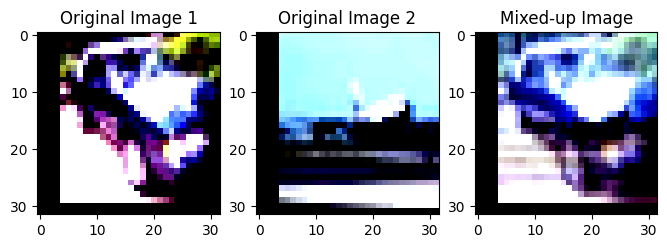


Total train accuarcy: tensor(20.1184)
Total train loss: 3390.3327946662903

[ Test epoch: 0 ]

Test accuarcy: 32.33
Test average loss: 0.05626950513124466
Model Saved!


In [198]:
#실제 동작부
for epoch in range(0,1):

    train(epoch)
    test(epoch)